In [102]:
# Core libraries
import numpy as np
import pandas as pd

# Data download
import yfinance as yf

# Models and preprocessing
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [106]:
# Download daily OHLCV data for SMCI from Yahoo Finance
ticker = "SMCI"
df = yf.download(ticker, start="2017-01-01", progress=False)

# Keep only core columns and ensure dates are sorted
df = df[["Open", "High", "Low", "Close", "Volume"]].copy()
df = df.sort_index()

print("Raw data shape:", df.shape)
print(df.head())
print(df.tail())


Raw data shape: (2245, 5)
Price        Open   High    Low  Close   Volume
Ticker       SMCI   SMCI   SMCI   SMCI     SMCI
Date                                           
2017-01-03  2.825  2.875  2.813  2.845  1808000
2017-01-04  2.850  2.900  2.840  2.885  2532000
2017-01-05  2.870  2.900  2.820  2.855  1196000
2017-01-06  2.875  2.900  2.830  2.845  1413000
2017-01-09  2.845  2.890  2.825  2.825  1360000
Price            Open       High        Low      Close    Volume
Ticker           SMCI       SMCI       SMCI       SMCI      SMCI
Date                                                            
2025-12-01  33.369999  33.950001  32.570000  33.410000  20952400
2025-12-02  33.590000  34.330002  32.889999  32.919998  19434000
2025-12-03  33.000000  33.709999  32.669998  33.680000  16253200
2025-12-04  33.500000  34.410000  33.080002  34.230000  17205700
2025-12-05  33.849998  34.790001  33.450001  34.689999  19380600


/var/folders/rz/1gkj_9056tb0yp6hv42h69640000gn/T/ipykernel_91165/2795705756.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2017-01-01", progress=False)


In [108]:
# Make a copy so we don't mess with any internal yfinance state
df = df.copy()

# 1) Flatten columns: handle MultiIndex or tuple columns
#    e.g. ('Open', 'SMCI') -> 'Open', ('Open',) -> 'Open'
new_cols = []
for c in df.columns:
    if isinstance(c, tuple):
        # take the first non-empty piece as the name
        for part in c:
            if part not in (None, "", " "):
                new_cols.append(str(part))
                break
        else:
            new_cols.append("col")
    else:
        new_cols.append(str(c))

df.columns = new_cols

print("Columns after flattening:", list(df.columns))

# 2) Keep only OHLCV and sort by date
expected_cols = ["Open", "High", "Low", "Close", "Volume"]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(
        f"Expected columns {expected_cols}, but these are missing: {missing}. "
        "Check the download cell or print(df.head()) to inspect."
    )

df = df[expected_cols].copy()
df = df.sort_index()

print("\nNaNs per column before cleaning:")
print(df.isna().sum())

# 3) Drop rows with missing OHLCV values
df = df.dropna(subset=expected_cols)

# 4) Replace zero volume with NaN and forward-fill, then drop remaining NaNs in Volume
df["Volume"] = df["Volume"].replace(0, np.nan).ffill()
df = df.dropna(subset=["Volume"])

print("\nShape after cleaning:", df.shape)
print(df.head())
print(df.tail())


Columns after flattening: ['Open', 'High', 'Low', 'Close', 'Volume']

NaNs per column before cleaning:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Shape after cleaning: (2245, 5)
             Open   High    Low  Close   Volume
Date                                           
2017-01-03  2.825  2.875  2.813  2.845  1808000
2017-01-04  2.850  2.900  2.840  2.885  2532000
2017-01-05  2.870  2.900  2.820  2.855  1196000
2017-01-06  2.875  2.900  2.830  2.845  1413000
2017-01-09  2.845  2.890  2.825  2.825  1360000
                 Open       High        Low      Close    Volume
Date                                                            
2025-12-01  33.369999  33.950001  32.570000  33.410000  20952400
2025-12-02  33.590000  34.330002  32.889999  32.919998  19434000
2025-12-03  33.000000  33.709999  32.669998  33.680000  16253200
2025-12-04  33.500000  34.410000  33.080002  34.230000  17205700
2025-12-05  33.849998  34.790001  33.450001  34.689999  19380600


In [110]:
# ---- Feature engineering: returns, volatility, volume ----

# Log close for stable returns
df["log_close"] = np.log(df["Close"])

# 1-day log return
df["ret_1d"] = df["log_close"].diff()

# Rolling mean returns over different horizons
windows = [3, 5, 10, 21]
for w in windows:
    df[f"ret_mean_{w}d"] = df["ret_1d"].rolling(window=w).mean()

# 10-day rolling volatility of returns
df["ret_vol_10d"] = df["ret_1d"].rolling(window=10).std()

# Log volume and 1-day change
df["log_vol"] = np.log(df["Volume"])
df["log_vol_chg_1d"] = df["log_vol"].diff()

# Target: next-day log return
df["target_next_log_ret"] = df["log_close"].shift(-1) - df["log_close"]

# ---- Build model dataframe (features + target) ----

feature_cols = [
    "ret_1d",
    "ret_mean_3d",
    "ret_mean_5d",
    "ret_mean_10d",
    "ret_mean_21d",
    "ret_vol_10d",
    "log_vol_chg_1d",
]

# Start with all rows, then clean
df_tmp = df[feature_cols + ["target_next_log_ret"]].copy()

print("NaNs per column before cleaning:")
print(df_tmp.isna().sum())

# Drop rows with missing target (last day after shift)
df_tmp = df_tmp[df_tmp["target_next_log_ret"].notna()]

# Drop any remaining rows with NaNs in features
df_model = df_tmp.dropna().copy()

print("\nShape of df_model after cleaning:", df_model.shape)
print(df_model.head())


NaNs per column before cleaning:
ret_1d                  1
ret_mean_3d             3
ret_mean_5d             5
ret_mean_10d           10
ret_mean_21d           21
ret_vol_10d            10
log_vol_chg_1d          1
target_next_log_ret     1
dtype: int64

Shape of df_model after cleaning: (2223, 8)
              ret_1d  ret_mean_3d  ret_mean_5d  ret_mean_10d  ret_mean_21d  \
Date                                                                         
2017-02-02 -0.003914     0.000000    -0.022596     -0.006270     -0.005213   
2017-02-03  0.011696    -0.008294    -0.006858     -0.006925     -0.005321   
2017-02-06 -0.005831     0.000650     0.001173     -0.008229     -0.005101   
2017-02-07  0.017392     0.007752    -0.002664     -0.006130     -0.004105   
2017-02-08  0.005731     0.005764     0.005015     -0.008048     -0.003497   

            ret_vol_10d  log_vol_chg_1d  target_next_log_ret  
Date                                                          
2017-02-02     0.032763     

In [112]:
# Features, target, and dates
feature_cols = [
    "ret_1d",
    "ret_mean_3d",
    "ret_mean_5d",
    "ret_mean_10d",
    "ret_mean_21d",
    "ret_vol_10d",
    "log_vol_chg_1d",
]

X = df_model[feature_cols].values
y = df_model["target_next_log_ret"].values
dates = df_model.index

n = len(df_model)
print("Total samples:", n)

# Time-based 60/20/20 split (no shuffle)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

dates_train = dates[:train_end]
dates_val   = dates[train_end:val_end]
dates_test  = dates[val_end:]

print("Train size:", len(y_train))
print("Val size:  ", len(y_val))
print("Test size: ", len(y_test))


Total samples: 2223
Train size: 1333
Val size:   445
Test size:  445


In [114]:
def regression_metrics(y_true, y_pred):
    # Standard regression metrics for quick comparison
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)      # older sklearn: no 'squared' arg
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}



# ---- Simple trading strategy evaluation ----
def evaluate_strategy(y_true, y_pred, trading_days=252):
    """
    Rule: long when predicted next-day return > 0, otherwise flat.
    y_true / y_pred are daily *log* returns.
    """
    positions = (y_pred > 0).astype(int)          # 1 = long, 0 = flat
    strat_rets = positions * y_true               # strategy log-returns

    # Hit rate on return sign (ignoring exact zeros)
    sign_true = np.sign(y_true)
    sign_pred = np.sign(y_pred)
    mask = sign_true != 0
    hit_rate = np.mean(sign_true[mask] == sign_pred[mask]) if mask.sum() > 0 else np.nan

    # Annualized Sharpe (using daily returns)
    mean_ret = strat_rets.mean()
    std_ret = strat_rets.std(ddof=1)
    sharpe = np.sqrt(trading_days) * mean_ret / std_ret if std_ret > 0 else np.nan

    # Max drawdown (work in cumulative log-return → wealth space)
    cum_log = np.cumsum(strat_rets)
    wealth = np.exp(cum_log)
    running_max = np.maximum.accumulate(wealth)
    drawdowns = wealth / running_max - 1.0
    max_dd = drawdowns.min()

    return {
        "hit_rate": hit_rate,
        "mean_daily_ret": mean_ret,
        "annualized_sharpe": sharpe,
        "max_drawdown": max_dd,
    }


In [116]:
# ---- Naive baseline: always predict 0 next-day return ----
y_pred_val_naive = np.zeros_like(y_val)
y_pred_test_naive = np.zeros_like(y_test)

print("Naive baseline (val):", regression_metrics(y_val, y_pred_val_naive))
print("Naive baseline (test):", regression_metrics(y_test, y_pred_test_naive))

# Strategy stats: naive zero prediction means never trading (all positions = 0)
naive_strategy_stats = evaluate_strategy(y_test, y_pred_test_naive)
print("\nNaive strategy stats (test):", naive_strategy_stats)


# ---- Constant-mean baseline: predict train mean for all future days ----
const_mean = y_train.mean()

y_pred_val_const = np.full_like(y_val, const_mean)
y_pred_test_const = np.full_like(y_test, const_mean)

print("\nConstant-mean baseline (val):", regression_metrics(y_val, y_pred_val_const))
print("Constant-mean baseline (test):", regression_metrics(y_test, y_pred_test_const))

const_strategy_stats = evaluate_strategy(y_test, y_pred_test_const)
print("\nConstant-mean strategy stats (test):", const_strategy_stats)


Naive baseline (val): {'MAE': 0.0342151109269307, 'RMSE': 0.049783892675316264, 'R2': -0.016060555708103275}
Naive baseline (test): {'MAE': 0.04320569432153551, 'RMSE': 0.06316475129570685, 'R2': -0.0009283695374542322}

Naive strategy stats (test): {'hit_rate': 0.0, 'mean_daily_ret': 0.0, 'annualized_sharpe': nan, 'max_drawdown': 0.0}

Constant-mean baseline (val): {'MAE': 0.034145867842682434, 'RMSE': 0.04972223595271254, 'R2': -0.013545357850704765}
Constant-mean baseline (test): {'MAE': 0.04324588246024676, 'RMSE': 0.06318237692944238, 'R2': -0.0014870500643680007}

Constant-mean strategy stats (test): {'hit_rate': 0.4606741573033708, 'mean_daily_ret': -0.0019236839959320428, 'annualized_sharpe': -0.4831391053011492, 'max_drawdown': -0.8484096025557224}


In [118]:
# ---- Ridge regression with simple validation-based alpha tuning ----

alphas = np.logspace(-4, 2, 13)  # from 1e-4 to 1e2
best_alpha = None
best_val_rmse = np.inf
best_val_metrics = None

for alpha in alphas:
    model = Pipeline([
        ("scaler", StandardScaler()),   # standardize features
        ("ridge", Ridge(alpha=alpha))   # L2-regularized linear model
    ])
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    metrics_val = regression_metrics(y_val, y_val_pred)

    if metrics_val["RMSE"] < best_val_rmse:
        best_val_rmse = metrics_val["RMSE"]
        best_alpha = alpha
        best_val_metrics = metrics_val

print("Best alpha (Ridge):", best_alpha)
print("Best Ridge metrics on val:", best_val_metrics)

# ---- Refit Ridge on train+val with best alpha, then evaluate on test ----

X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

ridge_best = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_alpha))
])
ridge_best.fit(X_trainval, y_trainval)

y_test_pred_ridge = ridge_best.predict(X_test)
ridge_test_metrics = regression_metrics(y_test, y_test_pred_ridge)

print("\nRidge metrics on test:", ridge_test_metrics)

ridge_strategy_stats = evaluate_strategy(y_test, y_test_pred_ridge)
print("\nRidge strategy stats on test:", ridge_strategy_stats)


Best alpha (Ridge): 100.0
Best Ridge metrics on val: {'MAE': 0.03445550305786884, 'RMSE': 0.050096662954463106, 'R2': -0.028867582437705597}

Ridge metrics on test: {'MAE': 0.0436252598462762, 'RMSE': 0.06342081312616704, 'R2': -0.009060090093895523}

Ridge strategy stats on test: {'hit_rate': 0.46292134831460674, 'mean_daily_ret': -0.0017883628776833283, 'annualized_sharpe': -0.4711415205749862, 'max_drawdown': -0.7986309705584577}


In [120]:
# ---- Gradient Boosting with small manual hyperparameter grid ----

param_grid = [
    {"n_estimators": 200, "max_depth": 2, "learning_rate": 0.05},
    {"n_estimators": 300, "max_depth": 2, "learning_rate": 0.05},
    {"n_estimators": 300, "max_depth": 3, "learning_rate": 0.05},
    {"n_estimators": 300, "max_depth": 3, "learning_rate": 0.03},
]

best_params = None
best_val_rmse = np.inf
best_val_metrics = None

for params in param_grid:
    gb = GradientBoostingRegressor(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        learning_rate=params["learning_rate"],
        random_state=0,
    )
    gb.fit(X_train, y_train)
    y_val_pred = gb.predict(X_val)
    metrics_val = regression_metrics(y_val, y_val_pred)

    if metrics_val["RMSE"] < best_val_rmse:
        best_val_rmse = metrics_val["RMSE"]
        best_params = params
        best_val_metrics = metrics_val

print("Best GB params (val):", best_params)
print("Best GB metrics on val:", best_val_metrics)

# ---- Refit GB on train+val with best params, evaluate on test ----

gb_best = GradientBoostingRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    learning_rate=best_params["learning_rate"],
    random_state=0,
)
gb_best.fit(X_trainval, y_trainval)

y_test_pred_gb = gb_best.predict(X_test)
gb_test_metrics = regression_metrics(y_test, y_test_pred_gb)

print("\nGB metrics on test:", gb_test_metrics)

gb_strategy_stats = evaluate_strategy(y_test, y_test_pred_gb)
print("\nGB strategy stats on test:", gb_strategy_stats)


Best GB params (val): {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.05}
Best GB metrics on val: {'MAE': 0.03586290246251918, 'RMSE': 0.05169436370598092, 'R2': -0.09554009513034156}

GB metrics on test: {'MAE': 0.04403485862559936, 'RMSE': 0.06420534886856825, 'R2': -0.03417929341437431}

GB strategy stats on test: {'hit_rate': 0.449438202247191, 'mean_daily_ret': -0.0025079436324509626, 'annualized_sharpe': -0.7145019638116012, 'max_drawdown': -0.8151845430954167}


In [121]:
# Collect regression metrics
models_reg = {
    "naive_zero": regression_metrics(y_test, y_pred_test_naive),
    "const_mean": regression_metrics(y_test, y_pred_test_const),
    "ridge": ridge_test_metrics,
    "gb": gb_test_metrics,
}

# Collect strategy stats
models_strat = {
    "naive_zero": naive_strategy_stats,
    "const_mean": const_strategy_stats,
    "ridge": ridge_strategy_stats,
    "gb": gb_strategy_stats,
}

# Convert to DataFrames
reg_df = pd.DataFrame(models_reg).T
strat_df = pd.DataFrame(models_strat).T

print("Regression metrics on TEST:")
print(reg_df)

print("\nStrategy stats on TEST:")
print(strat_df)


Regression metrics on TEST:
                 MAE      RMSE        R2
naive_zero  0.043206  0.063165 -0.000928
const_mean  0.043246  0.063182 -0.001487
ridge       0.043625  0.063421 -0.009060
gb          0.044035  0.064205 -0.034179

Strategy stats on TEST:
            hit_rate  mean_daily_ret  annualized_sharpe  max_drawdown
naive_zero  0.000000        0.000000                NaN      0.000000
const_mean  0.460674       -0.001924          -0.483139     -0.848410
ridge       0.462921       -0.001788          -0.471142     -0.798631
gb          0.449438       -0.002508          -0.714502     -0.815185


In [122]:
# Buy-and-hold: always long one unit each day on the test set
y_pred_buyhold = np.ones_like(y_test)  # positive => always long

buyhold_stats = evaluate_strategy(y_test, y_pred_buyhold)
print("Buy-and-hold strategy stats (test):", buyhold_stats)


Buy-and-hold strategy stats (test): {'hit_rate': 0.4606741573033708, 'mean_daily_ret': -0.0019236839959320428, 'annualized_sharpe': -0.4831391053011492, 'max_drawdown': -0.8484096025557224}


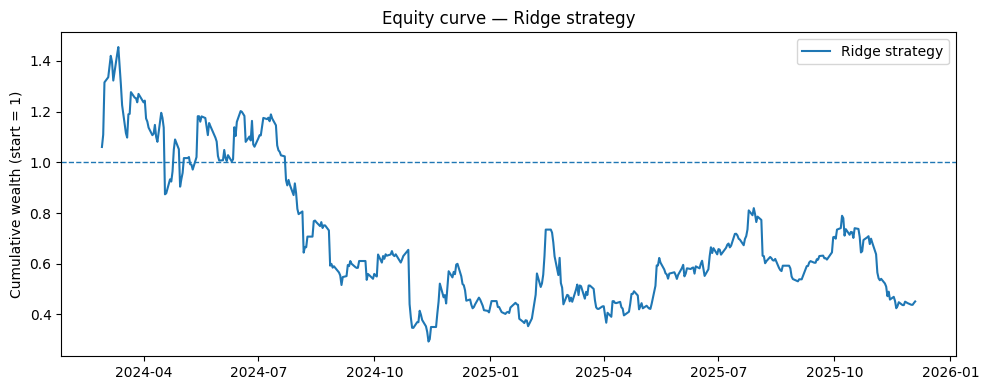

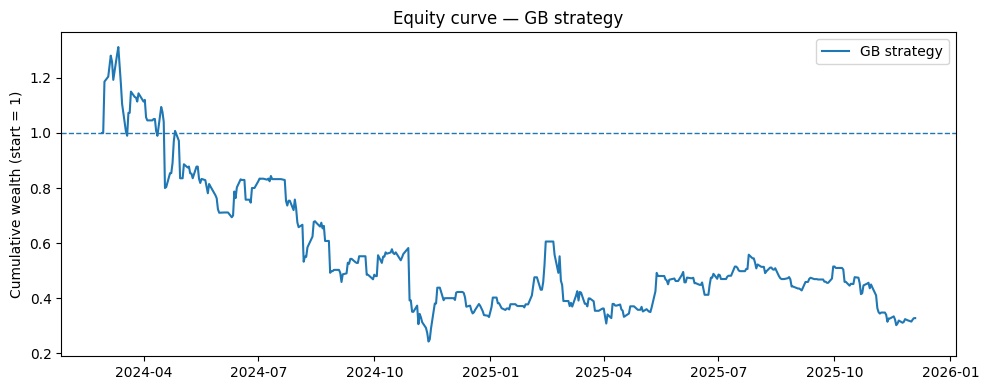

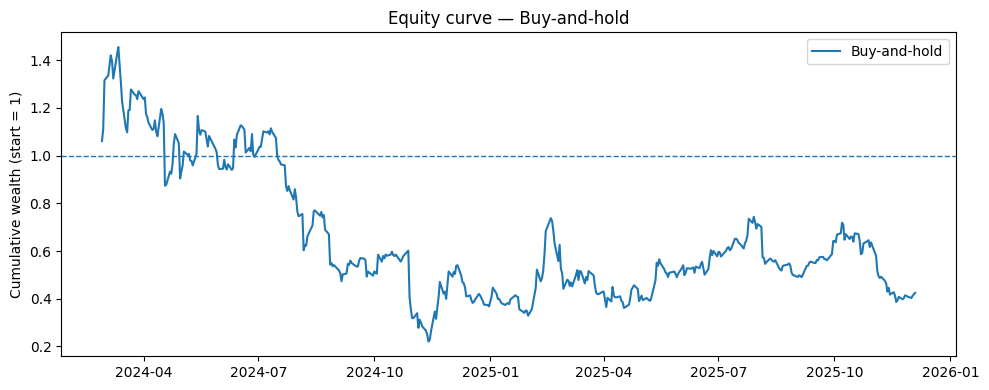

In [126]:
def plot_equity_curve(dates, y_true, y_pred, label):
    # Simple long/flat rule based on y_pred > 0
    positions = (y_pred > 0).astype(int)
    strat_rets = positions * y_true
    cum_log = np.cumsum(strat_rets)
    wealth = np.exp(cum_log)

    plt.figure(figsize=(10, 4))
    plt.plot(dates, wealth, label=label)
    plt.axhline(1.0, linestyle="--", linewidth=1)
    plt.ylabel("Cumulative wealth (start = 1)")
    plt.title(f"Equity curve — {label}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Ridge strategy
plot_equity_curve(dates_test, y_test, y_test_pred_ridge, "Ridge strategy")

# GB strategy
plot_equity_curve(dates_test, y_test, y_test_pred_gb, "GB strategy")

# Buy-and-hold (use y_pred as all ones so it's always long)
plot_equity_curve(dates_test, y_test, np.ones_like(y_test), "Buy-and-hold")


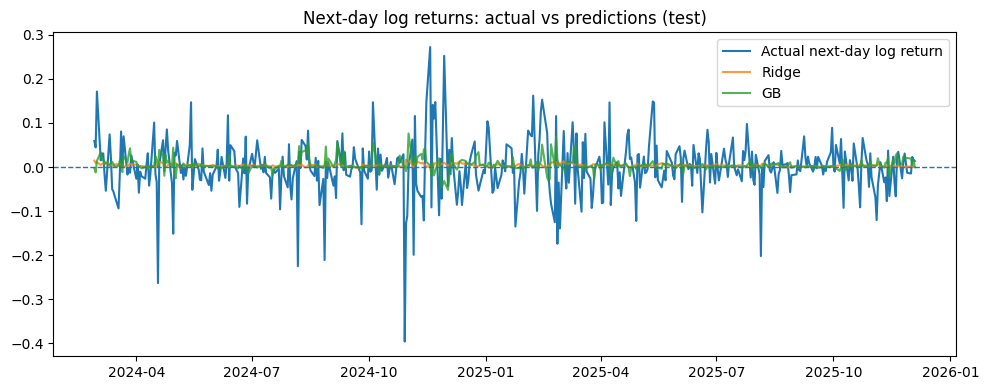

In [128]:
plt.figure(figsize=(10, 4))
plt.plot(dates_test, y_test, label="Actual next-day log return")
plt.plot(dates_test, y_test_pred_ridge, label="Ridge", alpha=0.8)
plt.plot(dates_test, y_test_pred_gb, label="GB", alpha=0.8)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Next-day log returns: actual vs predictions (test)")
plt.legend()
plt.tight_layout()
plt.show()


In [130]:
# Binary target: 1 if next-day return > 0, else 0
y_class = (df_model["target_next_log_ret"].values > 0).astype(int)

# Reuse same 60/20/20 split indices (train_end, val_end) and X_train/val/test
y_class_train = y_class[:train_end]
y_class_val   = y_class[train_end:val_end]
y_class_test  = y_class[val_end:]

print("Class balance (train):", np.mean(y_class_train))
print("Class balance (test): ", np.mean(y_class_test))


Class balance (train): 0.5138784696174044
Class balance (test):  0.4606741573033708


In [132]:
def classification_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


# Baseline: always predict majority class from train
majority_class = int(np.round(np.mean(y_class_train)))
print("Majority class (train):", majority_class)

y_val_major = np.full_like(y_class_val, majority_class)
y_test_major = np.full_like(y_class_test, majority_class)

print("Majority baseline (val):", classification_metrics(y_class_val, y_val_major))
print("Majority baseline (test):", classification_metrics(y_class_test, y_test_major))

# Strategy stats: 1 = long, 0 = flat
major_strategy_stats = evaluate_strategy(y_test, y_test_major)
print("\nMajority-class strategy stats (test):", major_strategy_stats)

Majority class (train): 1
Majority baseline (val): {'accuracy': 0.5685393258426966, 'precision': 0.5685393258426966, 'recall': 1.0, 'f1': 0.7249283667621776}
Majority baseline (test): {'accuracy': 0.4606741573033708, 'precision': 0.4606741573033708, 'recall': 1.0, 'f1': 0.6307692307692307}

Majority-class strategy stats (test): {'hit_rate': 0.4606741573033708, 'mean_daily_ret': -0.0019236839959320428, 'annualized_sharpe': -0.4831391053011492, 'max_drawdown': -0.8484096025557224}


In [134]:
log_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

log_clf.fit(X_train, y_class_train)

y_val_log = log_clf.predict(X_val)
y_test_log = log_clf.predict(X_test)

print("Logistic Regression (val):", classification_metrics(y_class_val, y_val_log))
print("Logistic Regression (test):", classification_metrics(y_class_test, y_test_log))

log_strategy_stats = evaluate_strategy(y_test, y_test_log)
print("\nLogistic strategy stats (test):", log_strategy_stats)

Logistic Regression (val): {'accuracy': 0.5325842696629214, 'precision': 0.5692307692307692, 'recall': 0.7312252964426877, 'f1': 0.6401384083044983}
Logistic Regression (test): {'accuracy': 0.4943820224719101, 'precision': 0.4742268041237113, 'recall': 0.8975609756097561, 'f1': 0.6205733558178752}

Logistic strategy stats (test): {'hit_rate': 0.4134831460674157, 'mean_daily_ret': -0.00010498550700411673, 'annualized_sharpe': -0.029641287208086894, 'max_drawdown': -0.7601234241485614}


In [136]:
rf_param_grid = [
    {"n_estimators": 200, "max_depth": 3},
    {"n_estimators": 300, "max_depth": 3},
    {"n_estimators": 300, "max_depth": 4},
]

best_rf = None
best_rf_params = None
best_val_acc = -np.inf
best_val_metrics = None

for params in rf_param_grid:
    rf = RandomForestClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        random_state=0,
        n_jobs=-1,
    )
    rf.fit(X_train, y_class_train)
    y_val_rf = rf.predict(X_val)
    metrics_val = classification_metrics(y_class_val, y_val_rf)

    if metrics_val["accuracy"] > best_val_acc:
        best_val_acc = metrics_val["accuracy"]
        best_rf = rf
        best_rf_params = params
        best_val_metrics = metrics_val

print("Best RF params:", best_rf_params)
print("Best RF metrics on val:", best_val_metrics)

y_test_rf = best_rf.predict(X_test)
rf_test_metrics = classification_metrics(y_class_test, y_test_rf)

print("\nRandom Forest metrics on test:", rf_test_metrics)

rf_strategy_stats = evaluate_strategy(y_test, y_test_rf)
print("\nRandom Forest strategy stats (test):", rf_strategy_stats)


Best RF params: {'n_estimators': 300, 'max_depth': 3}
Best RF metrics on val: {'accuracy': 0.5280898876404494, 'precision': 0.5743944636678201, 'recall': 0.6561264822134387, 'f1': 0.6125461254612546}

Random Forest metrics on test: {'accuracy': 0.4786516853932584, 'precision': 0.4628099173553719, 'recall': 0.8195121951219512, 'f1': 0.5915492957746479}

Random Forest strategy stats (test): {'hit_rate': 0.3775280898876405, 'mean_daily_ret': -0.001369534652958862, 'annualized_sharpe': -0.3989161535697626, 'max_drawdown': -0.758246778630714}


In [137]:
class_results = {
    "majority": classification_metrics(y_class_test, y_test_major),
    "logistic": classification_metrics(y_class_test, y_test_log),
    "rf": rf_test_metrics,
}

class_df = pd.DataFrame(class_results).T
print("Classification metrics on TEST (direction prediction):")
print(class_df)


Classification metrics on TEST (direction prediction):
          accuracy  precision    recall        f1
majority  0.460674   0.460674  1.000000  0.630769
logistic  0.494382   0.474227  0.897561  0.620573
rf        0.478652   0.462810  0.819512  0.591549


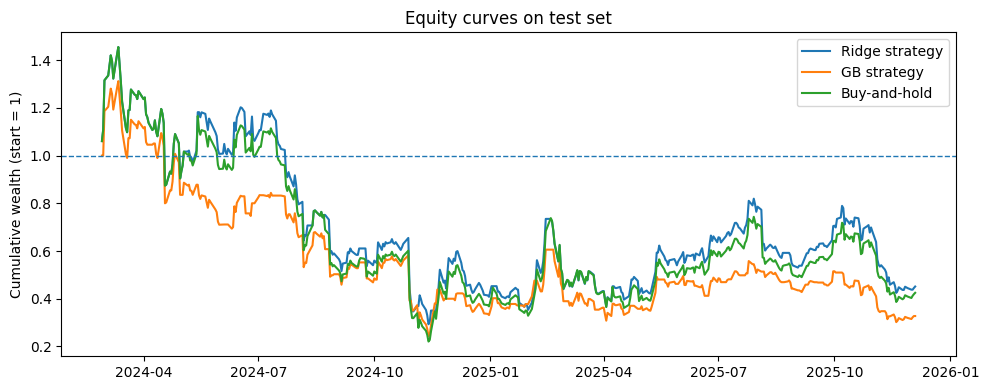

In [138]:
# Combined equity curves on the TEST period

def equity_curve_from_predictions(y_true, y_pred):
    """Long if prediction > 0, else flat; return cumulative wealth series."""
    positions = (y_pred > 0).astype(int)
    strat_rets = positions * y_true
    cum_log = np.cumsum(strat_rets)
    wealth = np.exp(cum_log)
    return wealth

plt.figure(figsize=(10, 4))

# Ridge strategy
wealth_ridge = equity_curve_from_predictions(y_test, y_test_pred_ridge)
plt.plot(dates_test, wealth_ridge, label="Ridge strategy")

# GB strategy
wealth_gb = equity_curve_from_predictions(y_test, y_test_pred_gb)
plt.plot(dates_test, wealth_gb, label="GB strategy")

# Buy-and-hold: always long (pretend all predictions are > 0)
wealth_buyhold = equity_curve_from_predictions(y_test, np.ones_like(y_test))
plt.plot(dates_test, wealth_buyhold, label="Buy-and-hold")

plt.axhline(1.0, linestyle="--", linewidth=1)
plt.ylabel("Cumulative wealth (start = 1)")
plt.title("Equity curves on test set")
plt.legend()
plt.tight_layout()
plt.show()

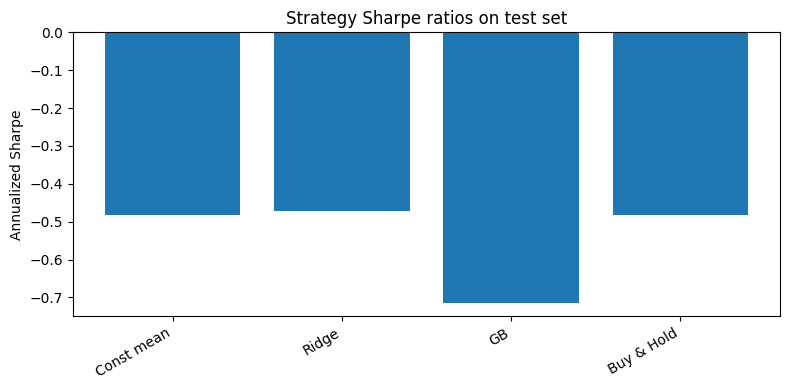

In [139]:
# Sharpe comparison across strategies

strategy_sharpes = {
    "Naive (zero)": naive_strategy_stats["annualized_sharpe"],
    "Const mean":   const_strategy_stats["annualized_sharpe"],
    "Ridge":        ridge_strategy_stats["annualized_sharpe"],
    "GB":           gb_strategy_stats["annualized_sharpe"],
    "Buy & Hold":   buyhold_stats["annualized_sharpe"],
}

names = list(strategy_sharpes.keys())
values = [strategy_sharpes[k] for k in names]

plt.figure(figsize=(8, 4))
plt.bar(names, values)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Annualized Sharpe")
plt.title("Strategy Sharpe ratios on test set")
plt.tight_layout()
plt.show()


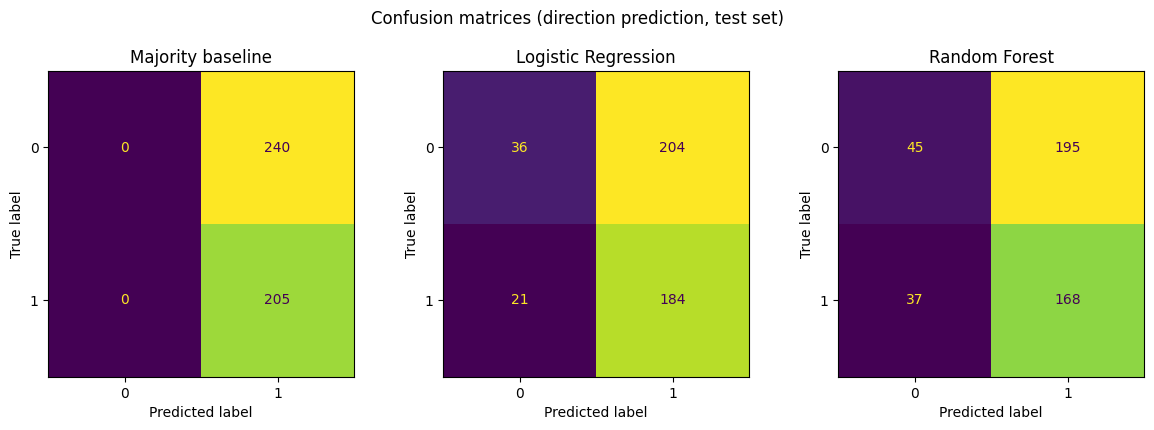

In [143]:
# Confusion matrices for majority baseline, Logistic Regression, and RF

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Majority baseline
cm_major = confusion_matrix(y_class_test, y_test_major)
ConfusionMatrixDisplay(cm_major, display_labels=[0, 1]).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Majority baseline")

# Logistic Regression
cm_log = confusion_matrix(y_class_test, y_test_log)
ConfusionMatrixDisplay(cm_log, display_labels=[0, 1]).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Logistic Regression")

# Random Forest
cm_rf = confusion_matrix(y_class_test, y_test_rf)
ConfusionMatrixDisplay(cm_rf, display_labels=[0, 1]).plot(ax=axes[2], colorbar=False)
axes[2].set_title("Random Forest")

fig.suptitle("Confusion matrices (direction prediction, test set)", y=1.02)
plt.tight_layout()
plt.show()

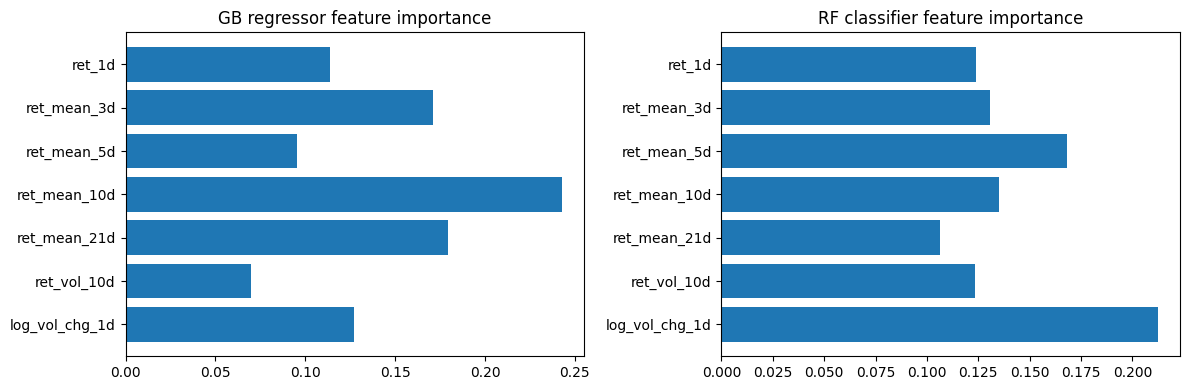

In [146]:
# Feature importance for GB (regression) and RF (classification)

feat_names = feature_cols  # reuse from earlier

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# GB regressor feature importance
gb_importance = gb_best.feature_importances_
axes[0].barh(feat_names, gb_importance)
axes[0].set_title("GB regressor feature importance")
axes[0].invert_yaxis()  # largest at top

# RF classifier feature importance
rf_importance = best_rf.feature_importances_
axes[1].barh(feat_names, rf_importance)
axes[1].set_title("RF classifier feature importance")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [148]:
# Binary labels: 1 = up day, 0 = down or flat
y_class = (df_model["target_next_log_ret"].values > 0).astype(int)

# Same split indices as before
y_class_train = y_class[:train_end]
y_class_val   = y_class[train_end:val_end]
y_class_test  = y_class[val_end:]

def class_proportions(y, name):
    unique, counts = np.unique(y, return_counts=True)
    props = {int(k): v / len(y) for k, v in zip(unique, counts)}
    print(f"{name} counts:", dict(zip(unique, counts)))
    print(f"{name} proportions:", props, "\n")

class_proportions(y_class_train, "Train")
class_proportions(y_class_val,   "Val")
class_proportions(y_class_test,  "Test")


Train counts: {0: 648, 1: 685}
Train proportions: {0: 0.48612153038259565, 1: 0.5138784696174044} 

Val counts: {0: 192, 1: 253}
Val proportions: {0: 0.4314606741573034, 1: 0.5685393258426966} 

Test counts: {0: 240, 1: 205}
Test proportions: {0: 0.5393258426966292, 1: 0.4606741573033708} 



In [150]:
# Correlation matrix heatmap for features + target
cols_for_corr = feature_cols + ["target_next_log_ret"]
corr = df_model[cols_for_corr].corr()

plt.figure(figsize=(8, 6))
im = plt.imshow(corr, interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(cols_for_corr)), cols_for_corr, rotation=45, ha="right")
plt.yticks(range(len(cols_for_corr)), cols_for_corr)
plt.title("Correlation matrix: features and next-day log return")
plt.tight_layout()

plt.savefig("corr_matrix_smci.png", dpi=300, bbox_inches="tight")
plt.close()


In [151]:
# One summary figure: histograms of key features + target
key_cols = [
    "ret_1d",
    "ret_mean_5d",
    "ret_vol_10d",
    "log_vol_chg_1d",
    "target_next_log_ret",
]

import os
os.makedirs("figures", exist_ok=True)

n = len(key_cols)
cols = 3
rows = int(np.ceil(n / cols))

plt.figure(figsize=(12, 4 * rows))

for i, col in enumerate(key_cols, 1):
    plt.subplot(rows, cols, i)
    plt.hist(df_model[col], bins=40)
    plt.title(col)

plt.tight_layout()
plt.savefig("figures/smci_feature_hist_summary.png", dpi=300, bbox_inches="tight")
plt.close()


In [153]:
import os
os.makedirs("figures", exist_ok=True)

# Ridge tuning: validation RMSE vs alpha
alpha_list = np.logspace(-4, 2, 13)  # same range as before

ridge_results = []

for alpha in alpha_list:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=alpha))
    ])
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    metrics_val = regression_metrics(y_val, y_val_pred)
    ridge_results.append({
        "alpha": alpha,
        "val_rmse": metrics_val["RMSE"]
    })

ridge_df = pd.DataFrame(ridge_results)

plt.figure(figsize=(8, 4))
plt.plot(np.log10(ridge_df["alpha"]), ridge_df["val_rmse"], marker="o")
plt.xlabel(r"$\log_{10}(\alpha)$")
plt.ylabel("Validation RMSE")
plt.title("Ridge regression: validation RMSE vs regularization strength")
plt.tight_layout()
plt.savefig("figures/ridge_alpha_val_rmse.png", dpi=300, bbox_inches="tight")
plt.close()


In [155]:
# Gradient Boosting: validation RMSE across configurations
gb_param_grid = [
    {"n_estimators": 200, "max_depth": 2, "learning_rate": 0.05},
    {"n_estimators": 300, "max_depth": 2, "learning_rate": 0.05},
    {"n_estimators": 300, "max_depth": 3, "learning_rate": 0.05},
    {"n_estimators": 300, "max_depth": 3, "learning_rate": 0.03},
]

gb_results = []

for params in gb_param_grid:
    gb = GradientBoostingRegressor(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        learning_rate=params["learning_rate"],
        random_state=0,
    )
    gb.fit(X_train, y_train)
    y_val_pred = gb.predict(X_val)
    metrics_val = regression_metrics(y_val, y_val_pred)

    label = f"{params['n_estimators']} trees, depth {params['max_depth']}, lr {params['learning_rate']}"
    gb_results.append({
        "config": label,
        "val_rmse": metrics_val["RMSE"]
    })

gb_df = pd.DataFrame(gb_results)

plt.figure(figsize=(10, 4))
plt.bar(range(len(gb_df)), gb_df["val_rmse"])
plt.xticks(range(len(gb_df)), gb_df["config"], rotation=30, ha="right")
plt.ylabel("Validation RMSE")
plt.title("Gradient Boosting: validation RMSE across configurations")
plt.tight_layout()
plt.savefig("figures/gb_val_rmse_configs.png", dpi=300, bbox_inches="tight")
plt.close()


In [157]:
from sklearn.metrics import accuracy_score

# Binary labels already defined:
# y_class = (df_model["target_next_log_ret"].values > 0).astype(int)
# y_class_train = y_class[:train_end]
# y_class_val   = y_class[train_end:val_end]

# Majority baseline
majority_class = int(np.round(np.mean(y_class_train)))
y_val_major = np.full_like(y_class_val, majority_class)

val_acc_major = accuracy_score(y_class_val, y_val_major)

# Logistic Regression
log_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])
log_clf.fit(X_train, y_class_train)
y_val_log = log_clf.predict(X_val)
val_acc_log = accuracy_score(y_class_val, y_val_log)

# Random Forest grid
rf_param_grid = [
    {"n_estimators": 200, "max_depth": 3},
    {"n_estimators": 300, "max_depth": 3},
    {"n_estimators": 300, "max_depth": 4},
]

rf_results = []

for params in rf_param_grid:
    rf = RandomForestClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        random_state=0,
        n_jobs=-1,
    )
    rf.fit(X_train, y_class_train)
    y_val_rf = rf.predict(X_val)
    acc = accuracy_score(y_class_val, y_val_rf)

    label = f"RF: {params['n_estimators']} trees, depth {params['max_depth']}"
    rf_results.append({"config": label, "val_acc": acc})

# Build a combined bar chart
labels = ["Majority", "Logistic"] + [r["config"] for r in rf_results]
values = [val_acc_major, val_acc_log] + [r["val_acc"] for r in rf_results]

plt.figure(figsize=(10, 4))
plt.bar(range(len(labels)), values)
plt.xticks(range(len(labels)), labels, rotation=30, ha="right")
plt.ylabel("Validation accuracy")
plt.ylim(0.4, 0.7)
plt.title("Classification models: validation accuracy comparison")
plt.tight_layout()
plt.savefig("figures/class_val_accuracy_models.png", dpi=300, bbox_inches="tight")
plt.close()


In [158]:
# Sanity check: summarize test metrics for main regression models

def summarize_reg_model(name, y_true, y_pred, strat_stats):
    mets = regression_metrics(y_true, y_pred)
    print(f"{name}")
    print(f"  RMSE : {mets['RMSE']:.4f}")
    print(f"  MAE  : {mets['MAE']:.4f}")
    print(f"  R^2  : {mets['R2']:.4f}")
    print(f"  Sharpe (ann.): {strat_stats['annualized_sharpe']:.4f}")
    print("-" * 40)


# Constant-mean baseline (you already computed const_mean, y_pred_test_const, const_strategy_stats)
summarize_reg_model(
    "Constant-mean baseline",
    y_test,
    y_pred_test_const,
    const_strategy_stats,
)

# Ridge (uses y_test_pred_ridge and ridge_strategy_stats)
summarize_reg_model(
    "Ridge Regression",
    y_test,
    y_test_pred_ridge,
    ridge_strategy_stats,
)

# Gradient Boosting (uses y_test_pred_gb and gb_strategy_stats)
summarize_reg_model(
    "Gradient Boosting Regressor",
    y_test,
    y_test_pred_gb,
    gb_strategy_stats,
)

Constant-mean baseline
  RMSE : 0.0632
  MAE  : 0.0432
  R^2  : -0.0015
  Sharpe (ann.): -0.4831
----------------------------------------
Ridge Regression
  RMSE : 0.0634
  MAE  : 0.0436
  R^2  : -0.0091
  Sharpe (ann.): -0.4711
----------------------------------------
Gradient Boosting Regressor
  RMSE : 0.0642
  MAE  : 0.0440
  R^2  : -0.0342
  Sharpe (ann.): -0.7145
----------------------------------------


In [162]:
import time

def time_model(name, model, X_train, y_train, X_test):
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    t1 = time.perf_counter()
    _ = model.predict(X_test)
    t2 = time.perf_counter()
    train_time = t1 - t0
    infer_time = t2 - t1
    print(f"{name}")
    print(f"  Training time : {train_time:.4f} seconds")
    print(f"  Inference time: {infer_time:.6f} seconds")
    print("-" * 40)
    return train_time, infer_time


# 1) Ridge Regression (regression) — best alpha = 100.0
ridge_timed = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=100.0))
])

ridge_train_t, ridge_infer_t = time_model(
    "Ridge Regression",
    ridge_timed,
    X_train,
    y_train,
    X_test,
)


# 2) Gradient Boosting Regressor (regression)
# Best GB params you printed: n_estimators=200, max_depth=2, learning_rate=0.05
gb_timed = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=2,
    learning_rate=0.05,
    random_state=0,
)

gb_train_t, gb_infer_t = time_model(
    "Gradient Boosting Regressor",
    gb_timed,
    X_train,
    y_train,
    X_test,
)


# 3) Random Forest Classifier (direction prediction)
# Use the RF config you ended up using; adjust these if needed.
rf_timed = RandomForestClassifier(
    n_estimators=300,
    max_depth=3,
    random_state=0,
    n_jobs=-1,
)

rf_train_t, rf_infer_t = time_model(
    "Random Forest Classifier",
    rf_timed,
    X_train,
    y_class_train,
    X_test,
)


Ridge Regression
  Training time : 0.0041 seconds
  Inference time: 0.000551 seconds
----------------------------------------
Gradient Boosting Regressor
  Training time : 0.2362 seconds
  Inference time: 0.000354 seconds
----------------------------------------
Random Forest Classifier
  Training time : 0.1510 seconds
  Inference time: 0.026346 seconds
----------------------------------------


In [164]:
import os
os.makedirs("figures", exist_ok=True)

# Combine train + val to fit final models for interpretation
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

# -------- Ridge feature importance (coefficients) --------
ridge_final = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=100.0))
])
ridge_final.fit(X_trainval, y_trainval)

ridge_coefs = ridge_final.named_steps["ridge"].coef_
ridge_importance = np.abs(ridge_coefs)

plt.figure(figsize=(8, 4))
plt.bar(range(len(feature_cols)), ridge_importance)
plt.xticks(range(len(feature_cols)), feature_cols, rotation=30, ha="right")
plt.ylabel("Absolute coefficient")
plt.title("Ridge Regression feature importance (standardized inputs)")
plt.tight_layout()
plt.savefig("figures/ridge_feature_importance.png", dpi=300, bbox_inches="tight")
plt.close()

# -------- Gradient Boosting feature importance --------
gb_final = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=2,
    learning_rate=0.05,
    random_state=0,
)
gb_final.fit(X_trainval, y_trainval)

gb_importance = gb_final.feature_importances_

plt.figure(figsize=(8, 4))
plt.bar(range(len(feature_cols)), gb_importance)
plt.xticks(range(len(feature_cols)), feature_cols, rotation=30, ha="right")
plt.ylabel("Importance score")
plt.title("Gradient Boosting feature importance")
plt.tight_layout()
plt.savefig("figures/gb_feature_importance.png", dpi=300, bbox_inches="tight")
plt.close()


In [168]:
import os
os.makedirs("figures", exist_ok=True)

# Combine train + val and fit final Ridge model
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

ridge_final = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=100.0))
])
ridge_final.fit(X_trainval, y_trainval)

# Predictions on test set
y_test_pred_ridge_final = ridge_final.predict(X_test)

# Two most important features by absolute coefficient
ridge_coefs = ridge_final.named_steps["ridge"].coef_
abs_coefs = np.abs(ridge_coefs)
top_idx = np.argsort(-abs_coefs)[:2]
top_feat1, top_feat2 = top_idx[0], top_idx[1]

print("Top features:", feature_cols[top_feat1], "and", feature_cols[top_feat2])


Top features: ret_mean_3d and ret_vol_10d


In [170]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred_ridge_final, s=10)
lims = [min(y_test.min(), y_test_pred_ridge_final.min()),
        max(y_test.max(), y_test_pred_ridge_final.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("True next-day log return")
plt.ylabel("Predicted next-day log return")
plt.title("Ridge: true vs predicted (test set)")
plt.tight_layout()
plt.savefig("figures/ridge_true_vs_pred.png", dpi=300, bbox_inches="tight")
plt.close()


In [172]:
feat_name_1 = feature_cols[top_feat1]
x_feat_1 = X_test[:, top_feat1]

plt.figure(figsize=(6, 4))
plt.scatter(x_feat_1, y_test_pred_ridge_final, s=10)
plt.xlabel(feat_name_1)
plt.ylabel("Predicted next-day log return")
plt.title(f"Ridge predictions vs {feat_name_1} (test set)")
plt.tight_layout()
plt.savefig(f"figures/ridge_pred_vs_{feat_name_1}.png", dpi=300, bbox_inches="tight")
plt.close()


In [174]:
feat_name_2 = feature_cols[top_feat2]
x_feat_2 = X_test[:, top_feat2]

plt.figure(figsize=(6, 4))
plt.scatter(x_feat_2, y_test_pred_ridge_final, s=10)
plt.xlabel(feat_name_2)
plt.ylabel("Predicted next-day log return")
plt.title(f"Ridge predictions vs {feat_name_2} (test set)")
plt.tight_layout()
plt.savefig(f"figures/ridge_pred_vs_{feat_name_2}.png", dpi=300, bbox_inches="tight")
plt.close()


In [178]:
print("=== DATASET SUMMARY ===")
print("df_model shape:", df_model.shape)
print("Columns:", list(df_model.columns))
print()

print("Train / Val / Test sizes:")
print("  X_train:", X_train.shape[0])
print("  X_val  :", X_val.shape[0])
print("  X_test :", X_test.shape[0])
print()

print("Direction label distribution (train/val/test):")

def label_counts(name, y):
    vals, cnts = np.unique(y, return_counts=True)
    props = cnts / cnts.sum()
    print(f"{name}: ", dict(zip(vals, cnts)), "  props:", dict(zip(vals, props)))

label_counts("Train", y_class_train)
label_counts("Val  ", y_class_val)
label_counts("Test ", y_class_test)


=== DATASET SUMMARY ===
df_model shape: (2223, 8)
Columns: ['ret_1d', 'ret_mean_3d', 'ret_mean_5d', 'ret_mean_10d', 'ret_mean_21d', 'ret_vol_10d', 'log_vol_chg_1d', 'target_next_log_ret']

Train / Val / Test sizes:
  X_train: 1333
  X_val  : 445
  X_test : 445

Direction label distribution (train/val/test):
Train:  {0: 648, 1: 685}   props: {0: 0.48612153038259565, 1: 0.5138784696174044}
Val  :  {0: 192, 1: 253}   props: {0: 0.4314606741573034, 1: 0.5685393258426966}
Test :  {0: 240, 1: 205}   props: {0: 0.5393258426966292, 1: 0.4606741573033708}


In [180]:
print("=== FINAL HYPERPARAMETERS ===")

# Ridge
ridge_params = ridge_final.named_steps["ridge"].get_params()
print("Ridge alpha:", ridge_params["alpha"])

# Gradient Boosting
gb_params = gb_final.get_params()
print("GB n_estimators:", gb_params["n_estimators"])
print("GB max_depth   :", gb_params["max_depth"])
print("GB learning_rate:", gb_params["learning_rate"])

# Random Forest
rf_params = rf_timed.get_params()
print("RF n_estimators:", rf_params["n_estimators"])
print("RF max_depth   :", rf_params["max_depth"])


=== FINAL HYPERPARAMETERS ===
Ridge alpha: 100.0
GB n_estimators: 200
GB max_depth   : 2
GB learning_rate: 0.05
RF n_estimators: 300
RF max_depth   : 3


In [182]:
print("=== REGRESSION METRICS (TEST) ===")

def summarize_reg_model(name, y_true, y_pred, strat_stats):
    mets = regression_metrics(y_true, y_pred)
    print(name)
    print(f"  RMSE : {mets['RMSE']:.4f}")
    print(f"  MAE  : {mets['MAE']:.4f}")
    print(f"  R^2  : {mets['R2']:.4f}")
    print(f"  Sharpe (ann.): {strat_stats['annualized_sharpe']:.4f}")
    print("-" * 40)

summarize_reg_model(
    "Constant-mean baseline",
    y_test,
    y_pred_test_const,
    const_strategy_stats,
)

summarize_reg_model(
    "Ridge Regression",
    y_test,
    y_test_pred_ridge,
    ridge_strategy_stats,
)

summarize_reg_model(
    "Gradient Boosting Regressor",
    y_test,
    y_test_pred_gb,
    gb_strategy_stats,
)


=== REGRESSION METRICS (TEST) ===
Constant-mean baseline
  RMSE : 0.0632
  MAE  : 0.0432
  R^2  : -0.0015
  Sharpe (ann.): -0.4831
----------------------------------------
Ridge Regression
  RMSE : 0.0634
  MAE  : 0.0436
  R^2  : -0.0091
  Sharpe (ann.): -0.4711
----------------------------------------
Gradient Boosting Regressor
  RMSE : 0.0642
  MAE  : 0.0440
  R^2  : -0.0342
  Sharpe (ann.): -0.7145
----------------------------------------


In [184]:
print("=== CLASSIFICATION METRICS (TEST) ===")
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Majority baseline
majority_class = int(np.round(np.mean(y_class_train)))
y_test_major = np.full_like(y_class[val_end:], majority_class)

def class_metrics(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=1
    )
    print(name)
    print(f"  accuracy : {acc:.4f}")
    print(f"  precision: {prec:.4f}")
    print(f"  recall   : {rec:.4f}")
    print(f"  f1       : {f1:.4f}")
    print("-" * 40)

y_test_class = y_class[val_end:]

class_metrics("Majority", y_test_class, y_test_major)
class_metrics("Logistic", y_test_class, y_test_pred_log)
class_metrics("Random Forest", y_test_class, y_test_pred_rf)


=== CLASSIFICATION METRICS (TEST) ===
Majority
  accuracy : 0.4607
  precision: 0.4607
  recall   : 1.0000
  f1       : 0.6308
----------------------------------------


NameError: name 'y_test_pred_log' is not defined

In [186]:
print("=== TIMING SUMMARY (seconds) ===")
print("Ridge train :", ridge_train_t)
print("Ridge infer :", ridge_infer_t)
print("GB train    :", gb_train_t)
print("GB infer    :", gb_infer_t)
print("RF train    :", rf_train_t)
print("RF infer    :", rf_infer_t)


=== TIMING SUMMARY (seconds) ===
Ridge train : 0.004084707994479686
Ridge infer : 0.0005512500065378845
GB train    : 0.2361517499666661
GB infer    : 0.0003535409923642874
RF train    : 0.15101945895003155
RF infer    : 0.026346416037995368


In [188]:
print("=== TOP RIDGE FEATURES (by |coef|) ===")

ridge_coefs = ridge_final.named_steps["ridge"].coef_
abs_coefs = np.abs(ridge_coefs)
idx_sorted = np.argsort(-abs_coefs)

for i in range(len(feature_cols)):
    j = idx_sorted[i]
    print(f"{i+1}. {feature_cols[j]}  |coef| = {abs_coefs[j]:.6f}")


=== TOP RIDGE FEATURES (by |coef|) ===
1. ret_mean_3d  |coef| = 0.001456
2. ret_vol_10d  |coef| = 0.001413
3. ret_mean_5d  |coef| = 0.001357
4. ret_mean_21d  |coef| = 0.000921
5. ret_mean_10d  |coef| = 0.000736
6. ret_1d  |coef| = 0.000384
7. log_vol_chg_1d  |coef| = 0.000109


In [190]:
import os
os.makedirs("figures", exist_ok=True)

# Dates aligned with df_model rows
dates_all = df_model.index
dates_test = dates_all[val_end:]   # same slice as y_test

def equity_curve(y_true_log, y_pred_log):
    """
    y_true_log: true next-day log returns (test)
    y_pred_log: model predicted next-day log returns (test)
    Strategy: long if prediction > 0, flat otherwise.
    Returns cumulative wealth series starting at 1.0.
    """
    positions = (y_pred_log > 0).astype(int)          # 1 = long, 0 = flat
    strat_log_ret = positions * y_true_log            # log return when in the market
    simple_ret = np.exp(strat_log_ret) - 1.0          # convert log to simple returns
    wealth = (1.0 + simple_ret).cumprod()
    return wealth

wealth_const = equity_curve(y_test, y_pred_test_const)
wealth_ridge = equity_curve(y_test, y_test_pred_ridge)
wealth_gb    = equity_curve(y_test, y_test_pred_gb)

plt.figure(figsize=(10, 4))
plt.plot(dates_test, wealth_const, label="Constant-mean strategy")
plt.plot(dates_test, wealth_ridge, label="Ridge strategy")
plt.plot(dates_test, wealth_gb,    label="GB strategy")
plt.axhline(1.0, linestyle="--", linewidth=0.8)
plt.xlabel("Date")
plt.ylabel("Cumulative wealth (start = 1)")
plt.title("Cumulative wealth of simple long-or-flat strategies on test set")
plt.legend()
plt.tight_layout()
plt.savefig("figures/test_equity_curves.png", dpi=300, bbox_inches="tight")
plt.close()
